### HW 5

**Due** 4/19/19

Please do not copy and paste code from the internet.  Also do not manually transcribe code from the internet. :)  If you copy code then you will not get a good grade. 
    
Collaboration is allowed for teams of up to 3 collaborators with explicit attribution (say who you worked with!)



#### Regularization and Validation

##### Regularization

As we've seen in class the performance of a machine learning model can be conceptualized as 

performance = bias + variance.

In this equation _bias_ reflects the squared difference between the average final hypothesis (averaged over all possible training data) and the target function.  Variance, on the other hand, is the expected squared difference between a hypothesis produced by the model and the average final hypothesis. A complex $\mathcal{H}$ has low bias and high variance. A simple $\mathcal{H}$ has high bias and low variance.  The technical meaning of "performance" is the expected out of sample error of the final hypothesis (depending on the training data).

_Regularization_ is a method of tuning a model so that bias goes up and variance goes down.  Often the tradeoff is such that bias goes up only a little but variance goes down a lot, resulting in improved overall performance.

In this assignment you will implement forms of regularization for linear models and neural networks.  

##### Validation

Regularization introduces new parameters into a learning problem that are not optimized by the training process.  There is often a value (which we will denote by $\lambda$) which is adjustable and affects the degree of "penalty" assigned for complex hypotheses.  This is an example of a _hyperparameter_.  Other examples of hyperparameters are:

1. The architecture of a neural network (number of layers, nodes per layer).
2. The learning rate chosen for gradient descent.
3. The size of the variance in the initial weights in a neural network (what we call $\sigma$).

Somehow we must intelligently chose values for these hyperparameters when we produce a machine learning model.  Unlike learned parameters (such as $\bar{w}$) the machine learning algorithms do not help us choose hyperparameters.  

One way of choosing hyperparameters is using a validation set.  If you have not already, you should read the section of the book that describes how validation works.  Here is an okay "executive summary" (but you should really read the book for complete info): [https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7).  The lecture slides from amlbook.com should also be helpful.

In the assignment below you will use validation techniques to tune hyperparameters such as the regularization parameter $\lambda$. 

#### Importing our old code

In the cell below I import a module called `ourstuff`.  This is the code in the file `ourstuff.pyc` which is a compiled version of a lot of the code we've written in previous assignments. This will let us access functions that we need to use all the time, like `scaler`, `test_train_split`, and other things.  In particular we can use this module to allow you to use my neural network solution code while letting you continue to work on your own neural network.

After importing the module you can type `stf` "dot" "tab" to see some of the available functions. 




In [1]:
## Don't forget to run this cell :)
import ourstuff as stf


In [2]:
import numpy as np # run this too

Below we implement a transformation that expands a set of points into a matrix $Z$ in which the rows are [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials) evaluated on the points.

To determing a Legendre Polynomial of given degree we use the fact that 

$P_0(x) = 1$

and

$P_1(x) = x$

together with the recurrence

![legendre](legendre.svg)  

Equivalently $P_{n+1}(x) = \frac{2n+1}{n+1}xP_n(x) - \frac{n}{n+1}P_{n-1}(x)$.



These polynomials are an orthogonal basis for continuous functions on $[-1,1]$.  Because of that domain, we scale the data using baby_scale to put it roughly in that range.   Weirdly standard scaling works better than mean normalization on this particular dataset for reasons I don't understand.  

This transformation works _much_ better than just adding high powers. 

#### Part 1

Complete the function legendre_transform using the recurrence relation.

In [3]:
def baby_scale(x1,x2):
    """This is standard scaling z = (x-mu)/sigma.  Think of x1 and x2 as columns of data.
       This function uses standard scaling to scale column x2 according to the mu and sigma
       from x1.  Note that only the scaled x2 is returned."""
    mu = np.mean(x1)
    std = np.std(x1)
    return (x2-mu)/std
    
def legendre_transform(points,n):
    """This function takes a column of real numbers (called points) and returns a matrix Z.
       The columns of Z are : 
           0th column: a bias column of ones
           1st: a copy of 'points'
           ith (for 2<=i<=n): The degree i legendre polynomial P_i applied to 'points'
    """
    
    Z = np.ones((n+1)*points.shape[0]).reshape((points.shape[0],n+1))
    Z[:,1] = points
    for col in range(1,n):
        ## There is only one line missing here
        Z[:,col+1] = 1/(col+1)*((2*col+1)*points*Z[:,col] - col*Z[:,col-1]) # given by professor
        ## Use the recurrence given in the above markdown cell to define Z[:,col+1]
    return Z

In [4]:
### Testing for Part 1

A = np.arange(3)
legendre_transform(A,4)

array([[ 1.   ,  0.   , -0.5  , -0.   ,  0.375],
       [ 1.   ,  1.   ,  1.   ,  1.   ,  1.   ],
       [ 1.   ,  2.   ,  5.5  , 17.   , 55.375]])

#### Part 2

Here we will implement regularization for linear regression using the L2 penalty.

Complete the linear_fit function below so that it returns

$$(X^TX+\lambda I)^{-1}X^T\bar{y}.$$

The value $\lambda$ is the regularization parameter -- higher $\lambda$ means a simpler hypothesis. 

Note:  Unfortunately `lambda` is a Python keyword and we shouldn't use it as a variable name. Use something like `_lambda` or `lamby` instead.


In [8]:
def linear_fit(X,y,lamby=0.000001):
    #hi! hey ;)
    Xt = X.transpose()
    parentheses = (Xt.dot(X)) + (lamby)*np.identity(X.shape[1],dtype = None) # what is I here? Identity matrix?
    Xty = Xt.dot(y)
    return np.linalg.pinv(parentheses).dot(Xty)


def linear_predict(X,w):
    return X.dot(w)

In [9]:
## Testing for Part 2

A = np.arange(13)
C = (np.arange(13)%2)*2-1
B = legendre_transform(A,4)
linear_fit(B,C,0.1)

array([-6.74078093e-01,  8.45641719e-01, -1.99620202e-01,  1.54847173e-02,
       -3.74309180e-04])

#### Try it out...

Below we use the functions you wrote above to examine the effect of regularization.  The dimensionality of the data is fixed at 7 and a linear model is used to fit the data with different amounts of regularization.

Which value of $\lambda$ will give the best generalization?

As the value of lambda gets lower, we get a better generalization. The best here is when lambda is .0001. When lambda gets below 1, there are only slight changes but it is still noticeable that the closer it gets to 0, the better.


i,deg,lamby =  0 7 10000
i,deg,lamby =  1 7 1000
i,deg,lamby =  2 7 100
i,deg,lamby =  3 7 10
i,deg,lamby =  4 7 1
i,deg,lamby =  5 7 0.1
i,deg,lamby =  6 7 0.01
i,deg,lamby =  7 7 0.001


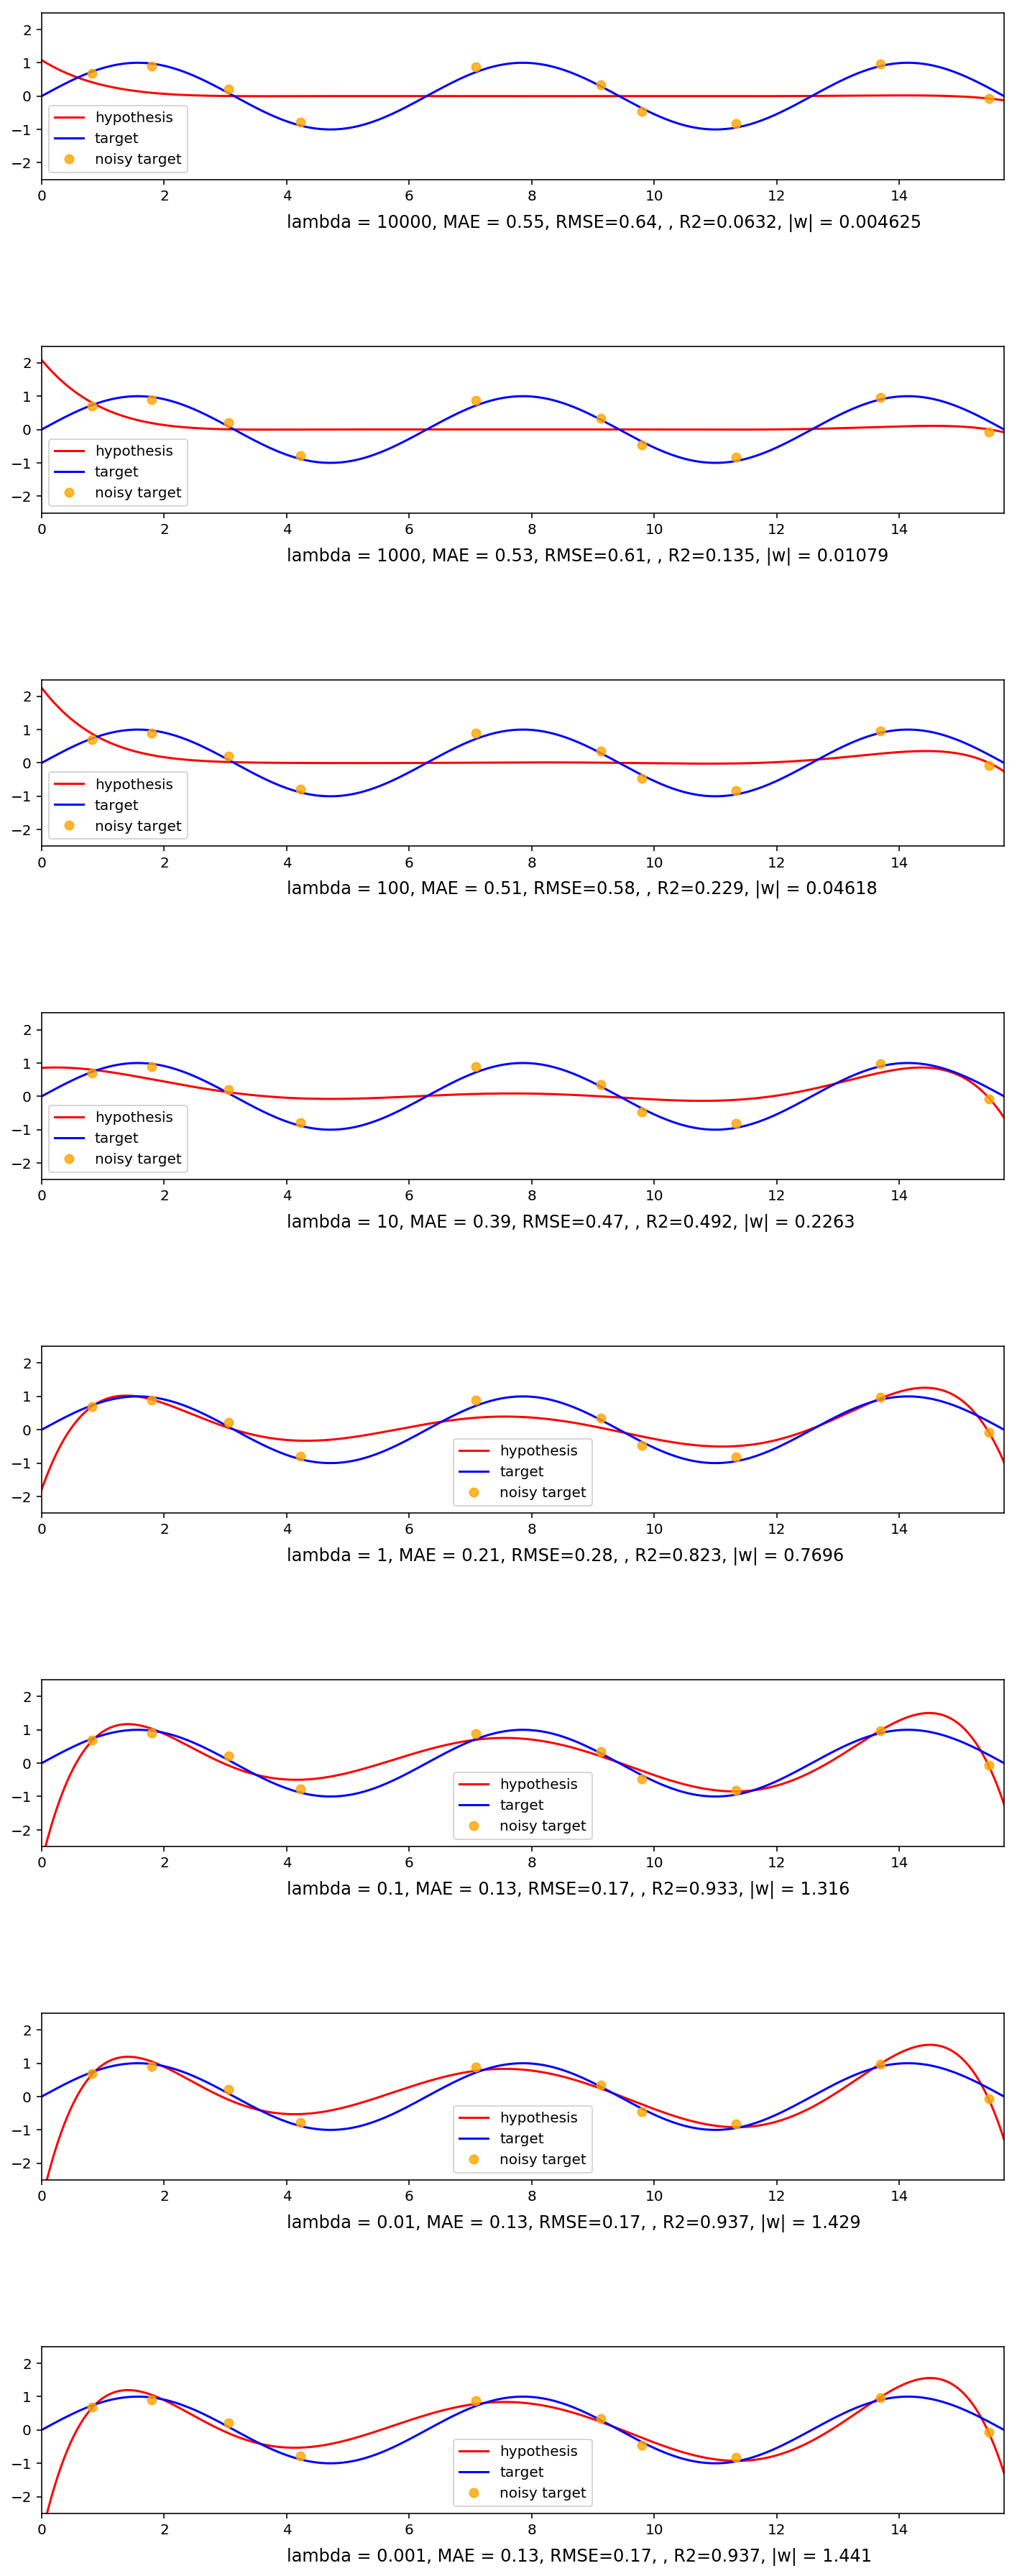

In [10]:

import numpy as np

import matplotlib.pyplot as plt


    
np.random.seed(230)

xmax = 5*np.pi
x = np.linspace(0,xmax,500)
N = 10
shuff = np.random.permutation(len(x))
x_pts = np.array(sorted(x[shuff][:N]))
Lambda = [10000,1000,100,10,1,0.1,0.01,0.001]

numfigs = len(Lambda)
fig,axes = plt.subplots(numfigs,1,figsize=(12,4*numfigs))

plt.subplots_adjust(hspace=1)

wt_by_lambda = dict()

deg = 7
X = legendre_transform(baby_scale(x_pts,x_pts),deg)

noise = np.random.randn(N)/3

y = np.sin(x_pts)+ noise/3

for i,lamby in enumerate(Lambda):
    print("i,deg,lamby = ",i,deg,lamby)




    
    w = linear_fit(X,y,lamby)
    g = linear_predict(X,w)


    wt_by_lambda[lamby] = tuple(w)
    
    xx = np.linspace(0,xmax,300)
    H = legendre_transform(baby_scale(x_pts,xx),deg)
    

    axes[i].plot(xx,H.dot(w),label="hypothesis",c='red')

    axes[i].plot(x,np.sin(x),label="target",c='blue')
    axes[i].plot(x_pts,y,'o',label="noisy target",alpha=0.8,c='orange')
    axes[i].legend()
    ymax = 2.5
    ymin = -2.5
    axes[i].axis([0,xmax,ymin,ymax])
    text = axes[i].text(4,ymin-1.3,f"lambda = {lamby}, MAE = {stf.MAE(g,y):0.2}, RMSE={stf.RMSE(g,y):0.2}, , R2={stf.R2(g,y):0.3}, |w| = {np.sqrt(w.dot(w)):0.4}", size=12, 
    verticalalignment='center')
plt.show()

#### Check...

Now examine the output below to confirm or disconfirm your guess.  Which value of $\lambda$ seems to give the best generalization? 

Following the output below, it seems that the value that gives lambda the best generalization is 1 and below. When lambda is higher, there is higher error.


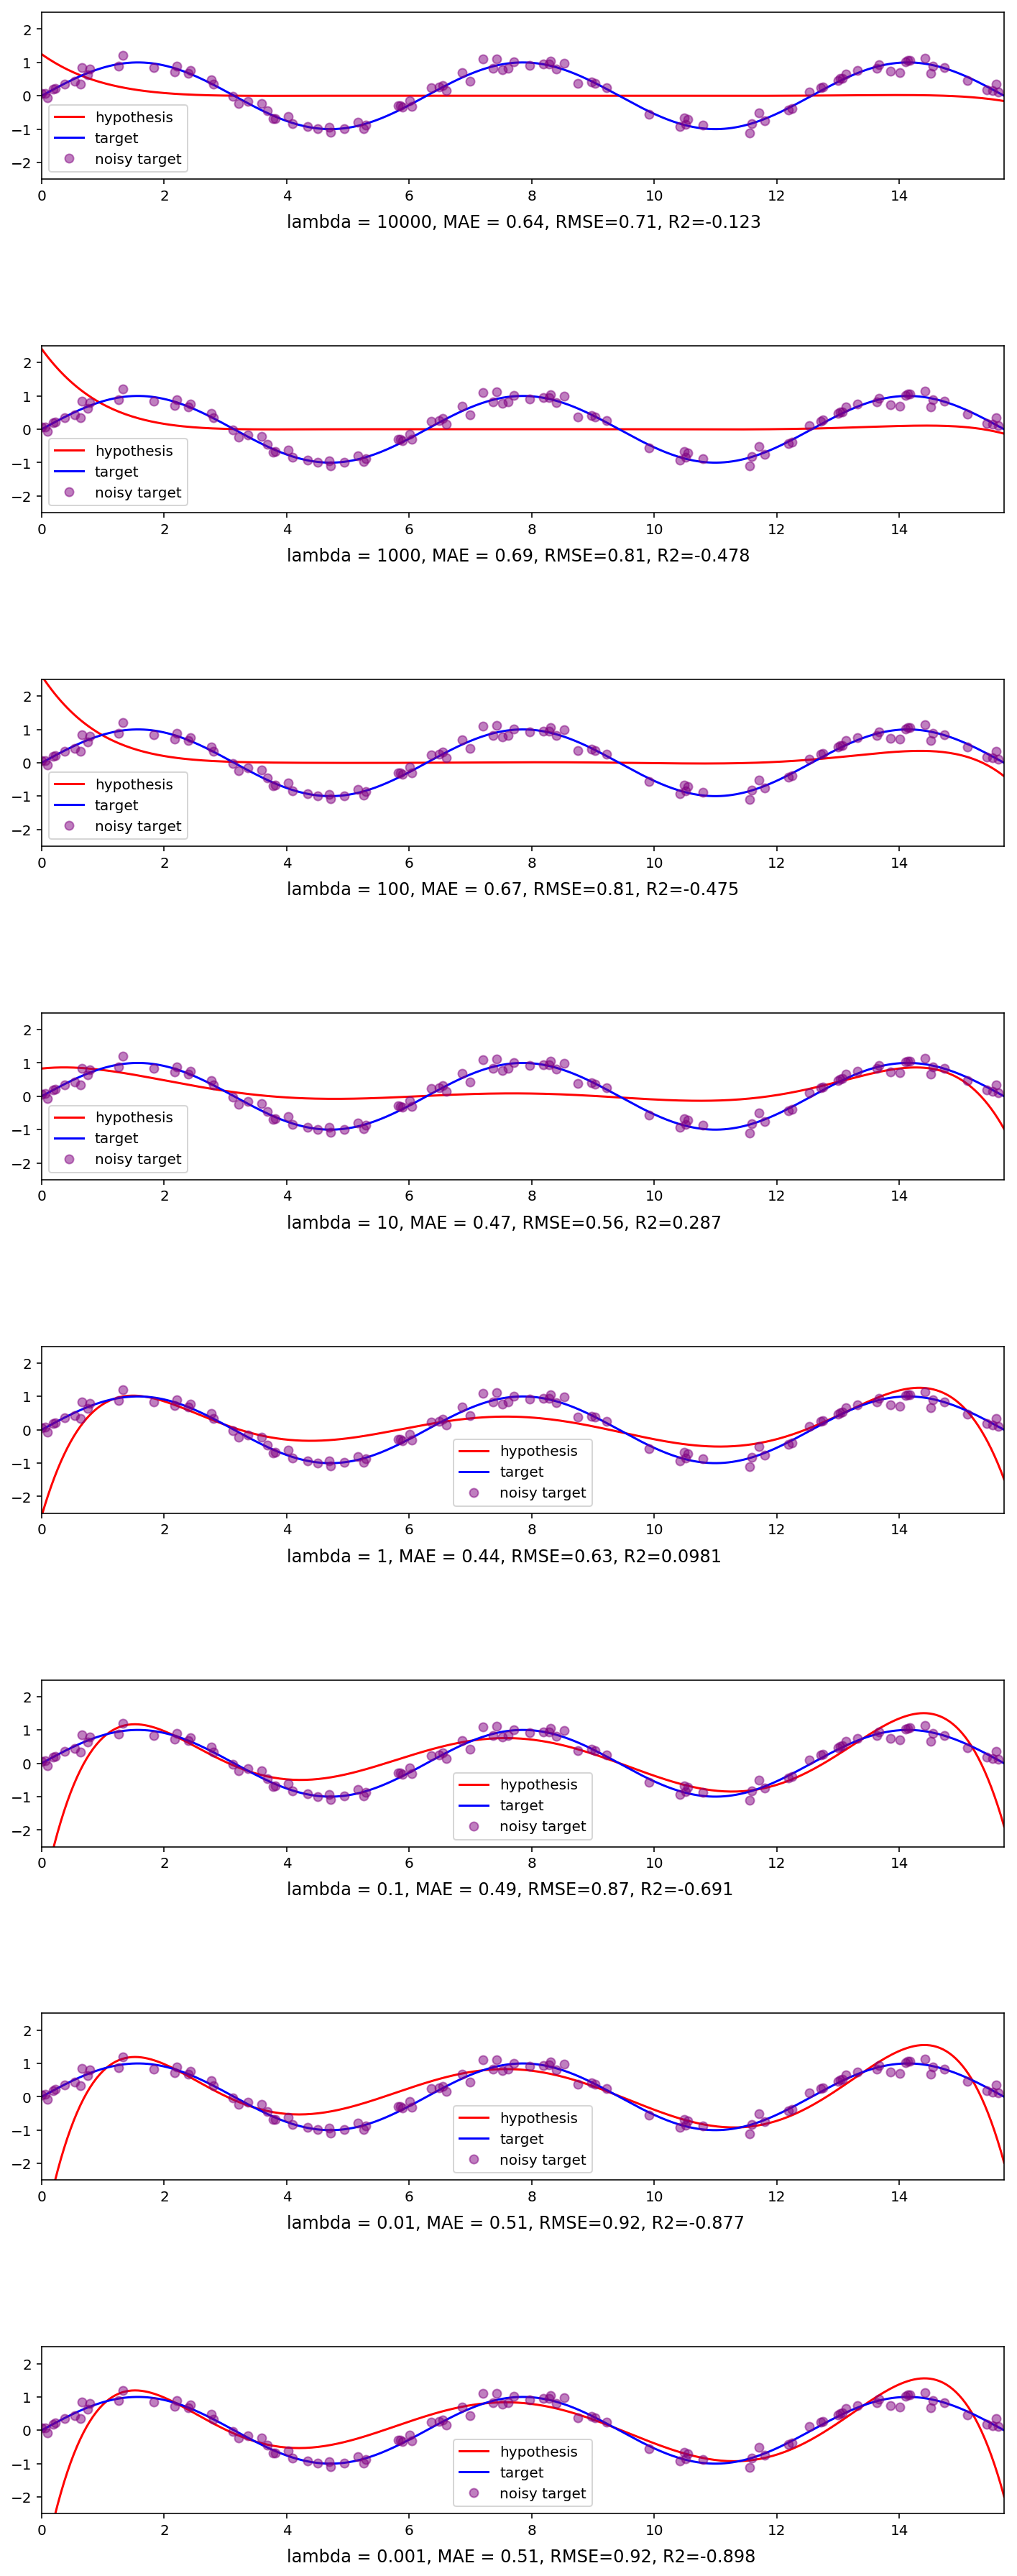

In [11]:

shuff = np.random.permutation(len(x))
M=10*N
x_pts = np.array(sorted(x[shuff][:M]))

fig,axes = plt.subplots(numfigs,1,figsize=(12,4*numfigs))

plt.subplots_adjust(hspace=1)
X = legendre_transform(baby_scale(x_pts,x_pts),deg)


y = np.sin(X[:,1])
noise = np.random.randn(M)/3

for i,lamby in enumerate(Lambda):
    


    y = np.sin(x_pts)+ noise/3

    w = wt_by_lambda[lamby]


    g = linear_predict(X,w)

    xx = np.linspace(0,xmax,300)
    
    H = legendre_transform(baby_scale(x_pts,xx),deg)
    

    axes[i].plot(xx,H.dot(w),label="hypothesis",c='red')

    axes[i].plot(x,np.sin(x),label="target",c='blue')
    axes[i].plot(x_pts,y,'o',label="noisy target",c='purple',alpha=0.5)
    axes[i].legend()
    ymax = 2.5
    ymin = -2.5
    axes[i].axis([0,xmax,ymin,ymax])

    text = axes[i].text(4,ymin-1.3,f"lambda = {lamby}, MAE = {stf.MAE(g,y):0.2}, RMSE={stf.RMSE(g,y):0.2}, R2={stf.R2(g,y):0.3}", size=12, 
    verticalalignment='center')
plt.show()

#### Lasso regression

The regularization technique we just implemented for linear regression minimized

$$E_{aug}(\bar{w}) = E_{in}(\bar{w}) + \frac{\lambda}{2}\bar{w}^T\bar{w} = E_{in}(\bar{w}) + \frac{\lambda}{2}\sum_{n=1}^N w_n^2$$

with respect to $\bar{w}$. 

That is, it penalized "complexity" where complexity was defined to be the square of the [L2 norm](http://mathworld.wolfram.com/L2-Norm.html) of the weight vector.  This is called Ridge Regression.

We can do the same thing, but with respect to the [L1 norm](http://mathworld.wolfram.com/L1-Norm.html) (which is known as Lasso Regression).

In that case we want to select the $\bar{w}$ that minimizes

$$E_{aug}(\bar{w})  = E_{in}(\bar{w}) + \frac{\lambda}{2}\sum_{n=1}^N |w_n|.$$

This presents the problem of how to compute the gradient of $\frac{\lambda}{2}\sum_{n=1}^N |w_n|$.  This is a little tricky, because the derivative of the absolute value function $f(x) = |x|$ is 1 for $x>0$, and -1 for $x<0$.  It is undefined exactly at $x=0$.  Nevertheless, in practice it works well to simply use $\frac{\lambda}{2}[sign(w_0), sign(w_1),\ldots, sign(w_d)]^T$ as the gradient of $\frac{\lambda}{2}\sum_{n=1}^N |w_n|$. Because $sign(0)=0$, this assigns a value of 0 to $f'(0)$. (Technically this is the "subgradient".)


#### Part 2.5

Adjust the code below so that `grad_des_lasso` performs Lasso regression. 

Note that this also implicitly implements logistic regression with L1 regularization, since the only difference is the gradient. 


In [12]:
def grad_lc(X,w,y):
    Xt = X.T
    return (Xt.dot(X).dot(w)-Xt.dot(y))/X.shape[0]
                
                

def grad_des_lasso(X,y,eta=0.1,iterations=1000,gradient=grad_lc,_lambda = 0):
    np.random.seed(100)
    assert(y.ndim==1)

    w = np.random.randn(X.shape[1])
    for _iterations in range(iterations):
        grad = gradient(X,w,y)
        ###adjust grad here!
        #grad = stf.E_in(X,w,y) + grad this is so wrong
        
        w = w - eta*grad

    return w


#### Testing Lasso

Let's rerun some of the experiments we did with Ridge regression with our new Lasso method.


i,deg,lamby =  0 7 1


i,deg,lamby =  1 7 0.1


i,deg,lamby =  2 7 0.01


i,deg,lamby =  3 7 0.001


i,deg,lamby =  4 7 0.0001


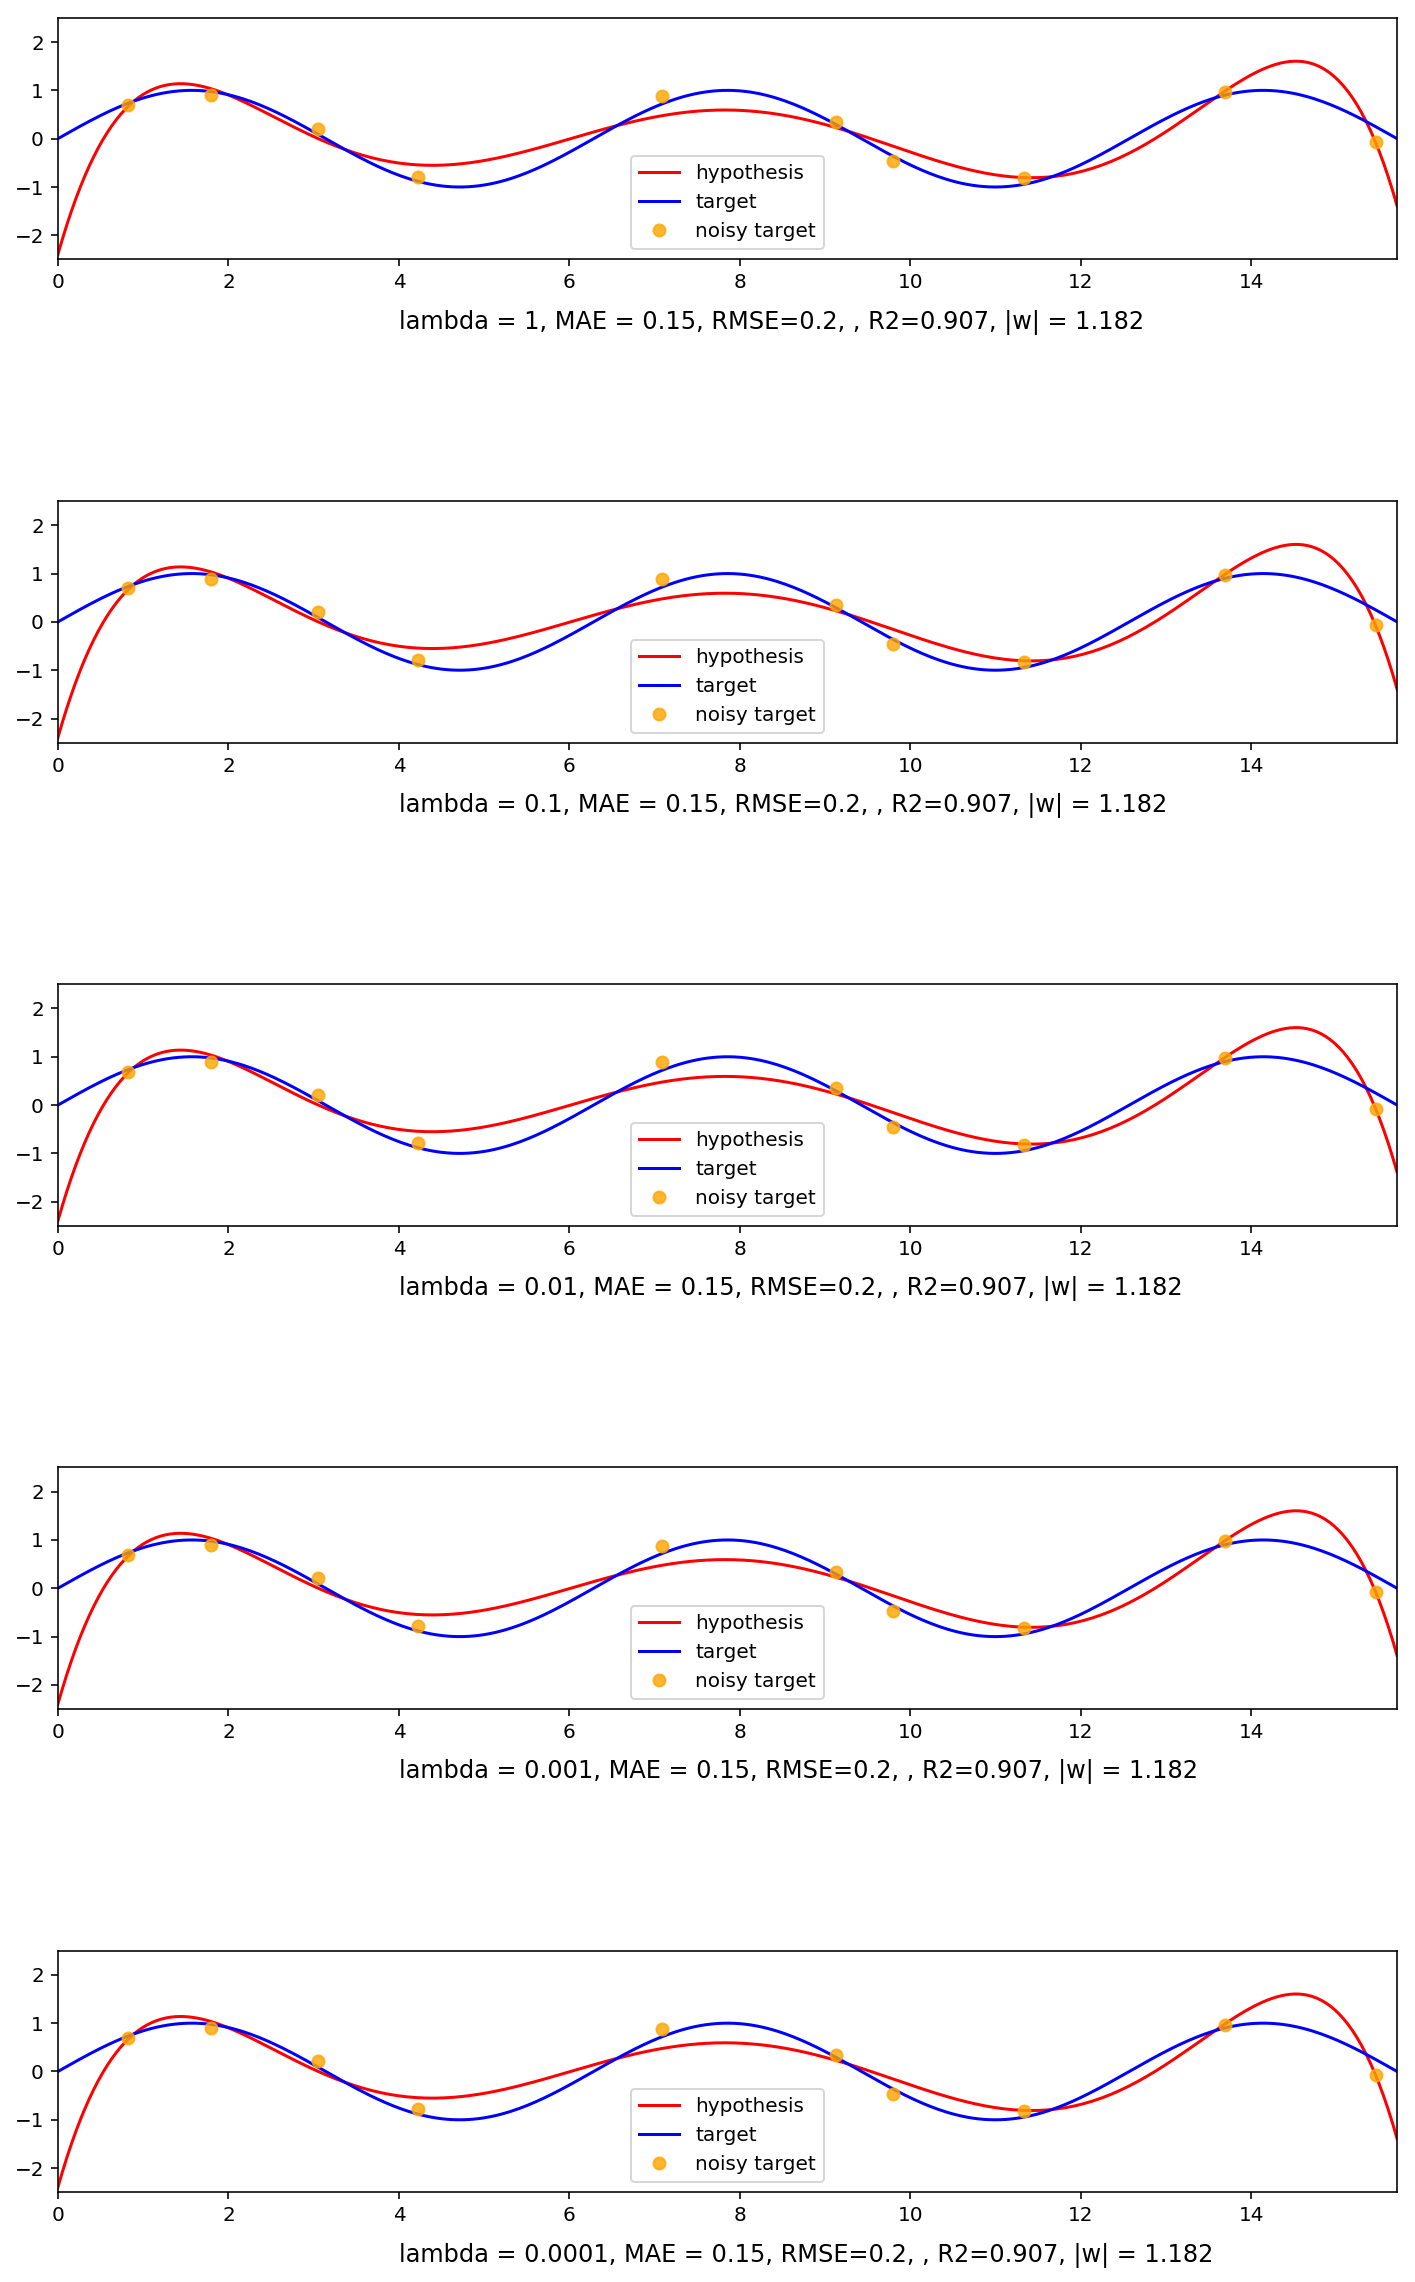

In [13]:

import numpy as np

import matplotlib.pyplot as plt


    
np.random.seed(230)

xmax = 5*np.pi
x = np.linspace(0,xmax,500)
N = 10
shuff = np.random.permutation(len(x))
x_pts = np.array(sorted(x[shuff][:N]))
Lambda = [1,0.1,0.01,0.001,0.0001]

numfigs = len(Lambda)
fig,axes = plt.subplots(numfigs,1,figsize=(12,4*numfigs))

plt.subplots_adjust(hspace=1)

wt_by_lambda = dict()

deg = 7
X = legendre_transform(baby_scale(x_pts,x_pts),deg)

noise = np.random.randn(N)/3

y = np.sin(x_pts)+ noise/3

for i,lamby in enumerate(Lambda):
    print("i,deg,lamby = ",i,deg,lamby)




    #w=grad_des_lasso(X,y,eta=0.001,iterations=200000,_lambda = lamby)
    w=grad_des_lasso(X,y,eta=0.0001,iterations=200000,_lambda = lamby)
    #w = linear_fit(X,y,lamby)
    g = linear_predict(X,w)


    wt_by_lambda[lamby] = tuple(w)
    
    xx = np.linspace(0,xmax,300)
    H = legendre_transform(baby_scale(x_pts,xx),deg)
    

    axes[i].plot(xx,H.dot(w),label="hypothesis",c='red')

    axes[i].plot(x,np.sin(x),label="target",c='blue')
    axes[i].plot(x_pts,y,'o',label="noisy target",alpha=0.8,c='orange')
    axes[i].legend()
    ymax = 2.5
    ymin = -2.5
    axes[i].axis([0,xmax,ymin,ymax])
    text = axes[i].text(4,ymin-1.3,f"lambda = {lamby}, MAE = {stf.MAE(g,y):0.2}, RMSE={stf.RMSE(g,y):0.2}, , R2={stf.R2(g,y):0.3}, |w| = {np.sqrt(w.dot(w)):0.4}", size=12, 
    verticalalignment='center')
plt.show()

##### Bias and Variance

We know that regularization decreases variance at the expense of increasing bias. 

It sounds fun to actually observe that happening.  We can use the example we have of the lines trying to learn points on $y=-\sin(x)$.  

In the code below find the line

    w = linear_fit(X,-np.sin(x1.T),lamby = 0)

Try adjusting the regularization parameter `lamby` to observe how it affects the bias and variance (as well as the distribution of $g^{(\mathcal{D})}$).

You should see that higher $\lambda$ means more bias and less variance.  


bias =  0.4864124279838621
variance =  0.00015112234354081042


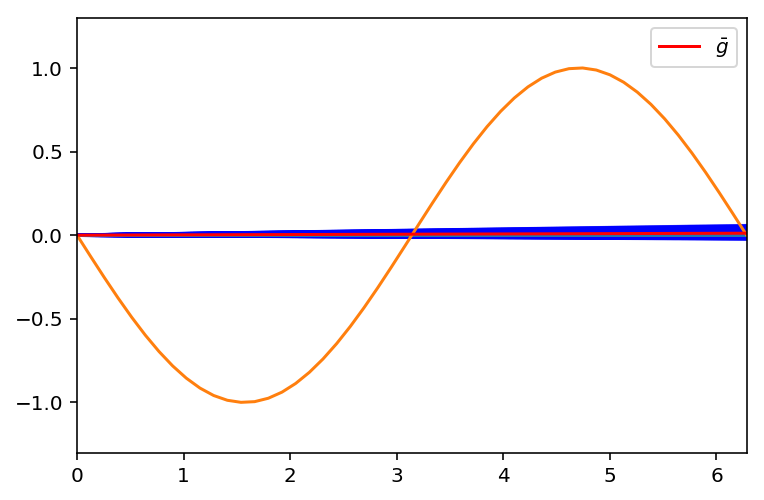

In [20]:
import numpy as np
import matplotlib.pyplot as plt

K = 1000 # how many times we'll chose a random dataset

domain = np.linspace(0,2*np.pi)
D = np.c_[np.ones(len(domain)),domain]
G = []
gbar = np.zeros(len(domain)).reshape((len(domain),1))

for k in range(K):
    x1 = np.random.rand(1,2)*np.pi*2
    X = np.c_[np.ones(2),x1.T]
    #w = np.linalg.pinv(X).dot(-np.sin(x1.T))
    w = linear_fit(X,-np.sin(x1.T),lamby = 1000)
    plt.plot(domain,D.dot(w),c='b',alpha=0.1)
    gbar += D.dot(w)
    G.append(D.dot(w))
gbar = gbar/K

tot = np.zeros(len(domain)).reshape((len(domain),1))
for g in G:
    tot += (g-gbar)**2
    
var_x = tot/len(G)

var = np.mean(var_x)




bias = np.mean((gbar.ravel()--np.sin(domain))**2)

print("bias = ",bias)
print("variance = ",var)
#plt.scatter(x1,[0,0])
#plt.scatter(x1,np.sin(x1))
plt.plot(domain,np.zeros(len(domain)))
plt.plot(domain,-np.sin(domain))
plt.plot(domain,gbar,c='r',label=r'$\bar{g}$')
plt.axis([0,2*np.pi,-1.3,1.3])
plt.legend()
plt.show()

#### Part 3:  Neural Network Regularization

In the theory of regularization, an error function that includes a complexity penalty is called _augmented error_. 

For a neural network, the L2 augmented error is

$$E_{aug}(\bar{w}) = E_{in}(\bar{w}) + \frac{\lambda}{N}\sum_{l,i,j}(w^{(l)}_{ij})^2$$

The last term in the above equation is just the L2 penalty dressed up using the neural network notation. 


The following equation shows how this affects the gradient of the neural network error function:

$$\frac{\partial E_{aug}(\bar{w})}{\partial W^{(l)}} = \frac{\partial E_{in}(\bar{w})}{\partial W^{(l)}} + \frac{2\lambda}{N}W^{(l)}$$

Since we are using stochastic gradient descent we need a version of this equation that applies only to the loss function ${\bf{e}}(\bar{x},\bar{w})$.  Because $\frac{2\lambda}{N}W^{(l)}$ is independent of $X$, this version is simply 

$$\frac{\partial {\bf{e}}_{aug}(\bar{w})}{\partial W^{(l)}} = \frac{\partial {\bf{e}}(\bar{w})}{\partial W^{(l)}} + \frac{2\lambda}{N}W^{(l)}.$$

In the version of neural network stochastic gradient descent below, all of the neural network functions are already implemented in `ourstuff`.  Also `_lambda` has already been added as a parameter.

Your job is to adjust `w_g` inside the `for` loop so that it corresponds to the augmented error gradient. 

In [22]:
def nn_stoch_grad_des(X,y,D_l,eta=0.01,iterations=1000,regression = False,sigma=1,_lambda = 0.00001,):
    np.random.seed(100)
    w = stf.init_nn(D_l,sigma)
    for _iterations in range(iterations):
        r = np.random.randint(X.shape[0])
        x = X[r]
        yi = y[r]
        xx,s = stf.forward_prop(x,w,regression)
        delta = stf.back_prop(xx,w,yi,regression)
        grad = stf.nn_gradient(xx,delta)
        new_w = []
        for wi,w_g in zip(w,grad):
            #adjust w_g here!
            w_g = _lambda/wi
            new_w.append(wi - eta*w_g)
        w = new_w
    return w

In [23]:
### Test stuff for Part 3

A = np.arange(13)
C = (np.arange(13)%2)*2-1
B = legendre_transform(A,4)
nn_stoch_grad_des(B,C,np.array([4,2,3,4,1]),_lambda=1)


[array([[  5.94757706,  -7.9617827 ],
        [-71.29977086,  -4.14125452],
        [ -0.68639671, -26.94903549],
        [ -4.86564465,  54.08707028],
        [  2.85040043,  28.69655567]]),
 array([[ 1.57963147e+02,  9.93734688e-01,  5.17665480e+00],
        [-1.34406186e+00, -1.58690601e+01, -3.64476508e+00],
        [ 3.74590209e+00,  1.41599848e-02, -8.32883265e+01]]),
 array([[ -4.6760545 ,  -3.6507816 ,   0.36178387,  18.01663759],
        [ -1.4350559 ,  86.63807268,  -1.68315154,  -2.3660068 ],
        [ -1.0984419 ,  16.03187871,  -1.64490856,  -1.25589197],
        [  0.26474992,  13.53343636,  -1.10916762, -14.35428978]]),
 array([[-4.42454222],
        [ 2.46118371],
        [-4.65369155],
        [-0.8293404 ],
        [-9.55414659]])]

### The ocular proof

The code below will let us visually understand how regularization works with a neural net. 

The two important lines are:

    D_l = np.array([X.shape[1]-1,5,2,1]) #architecture    
    w = stf.nn_stoch_grad_des(X,y,D_l,eta=0.1, sigma = 1,iterations = 20000,regression=regression,_lambda=lamby)
    g = stf.nn_predict_all(X,w,regression)

Experiment with changing some of the hyperparameters.  The neural net is a very fragile model.  

Note that the dataset is built on these lines:

    deg = 1
    X = legendre_transform(baby_scale(x_pts,x_pts),deg)
    
The degree 1 Legendre variable transformation only adds the bias column.  Try increasing the degree -- this model includes a transformation of variables _combined_ with a neural network.      

i,deg,lamby =  0 1 0.1


i,deg,lamby =  1 1 0.01


i,deg,lamby =  2 1 0.001


i,deg,lamby =  3 1 0.0001


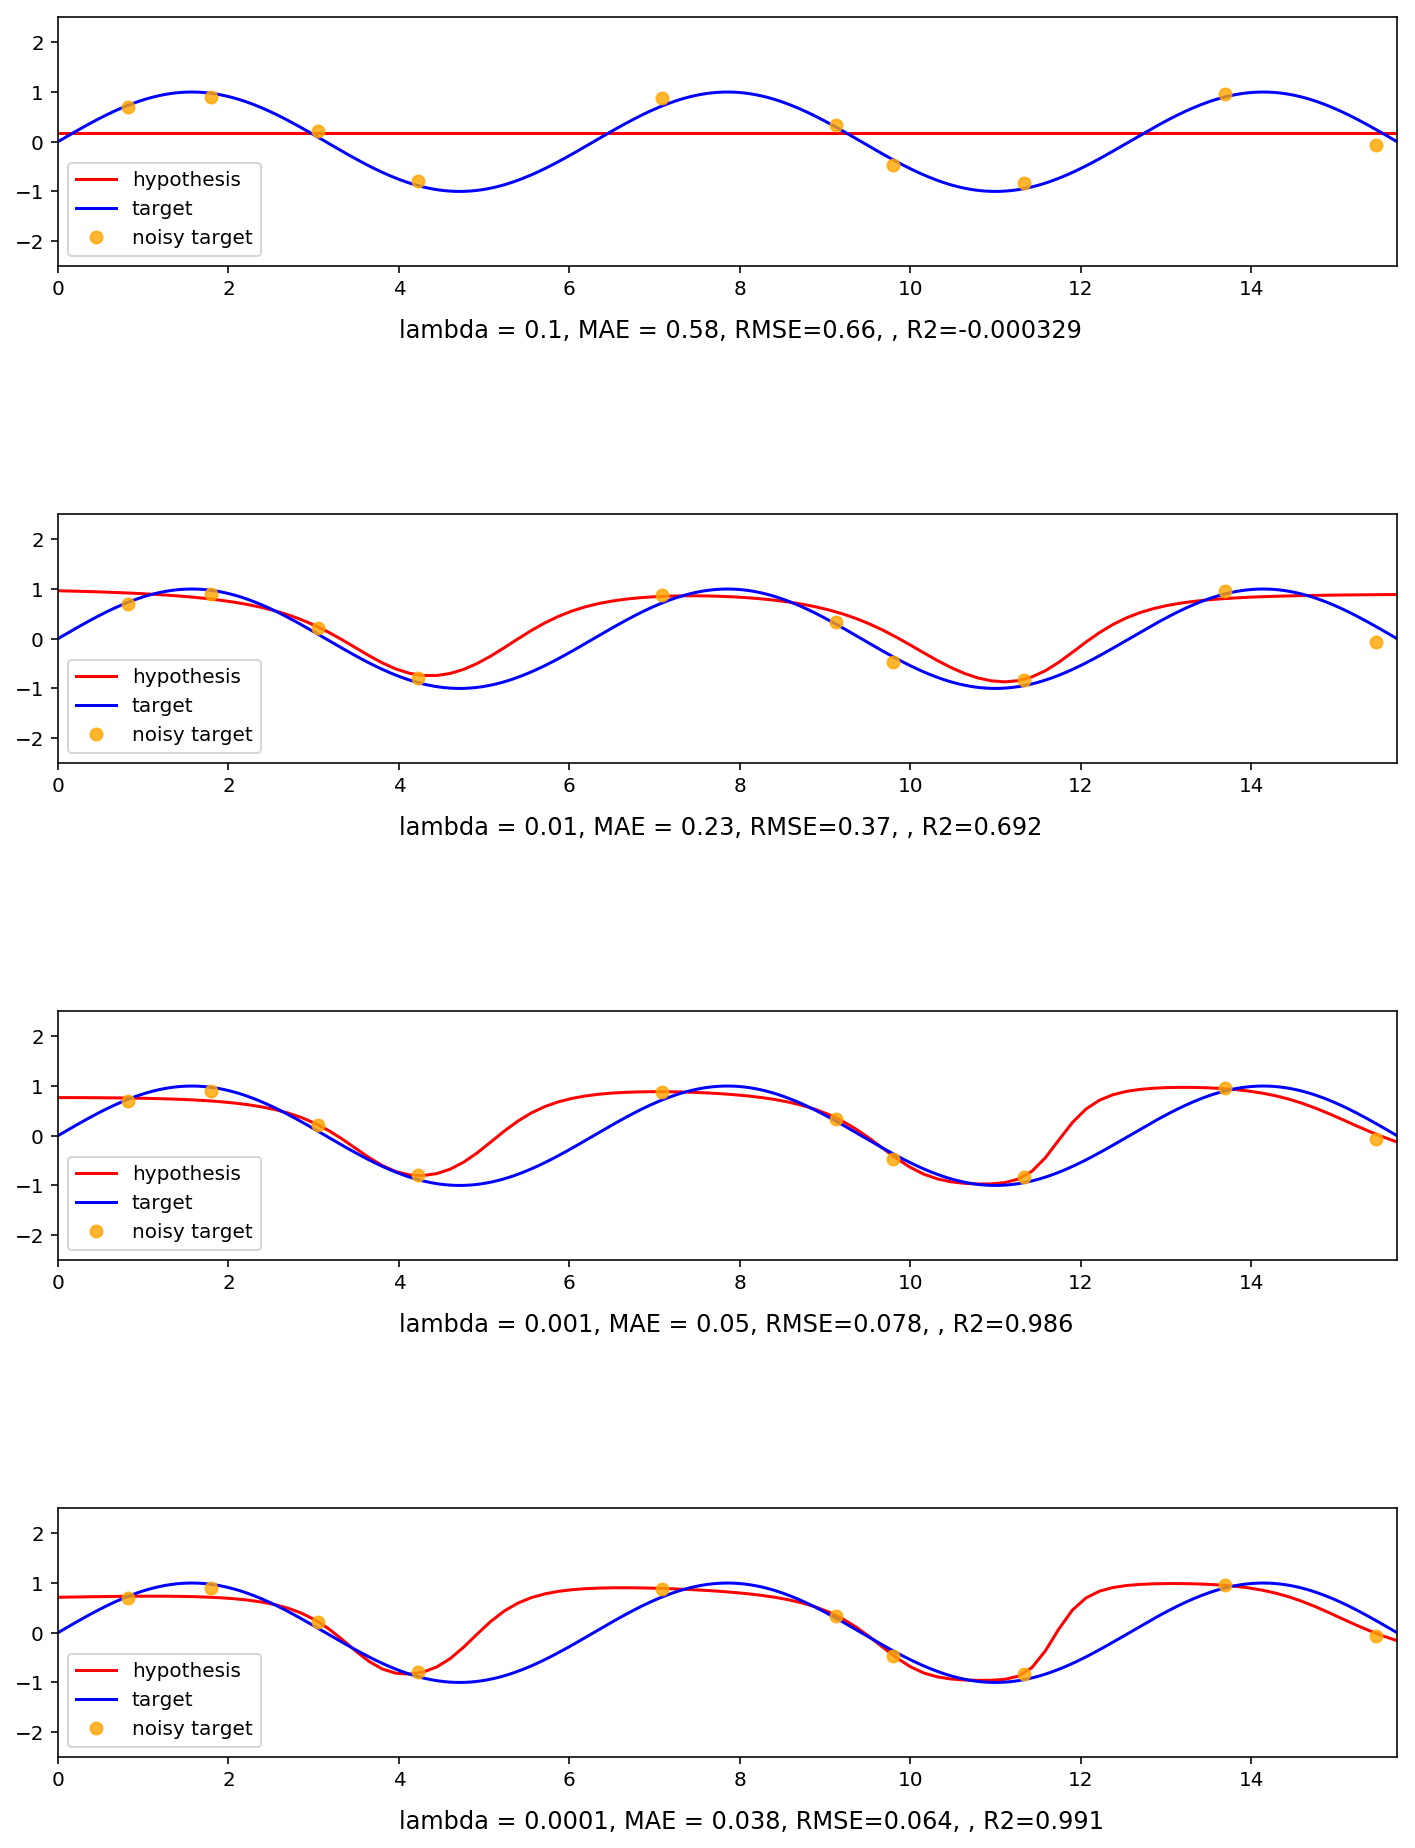

In [39]:

import numpy as np

import matplotlib.pyplot as plt


    
np.random.seed(230)

xmax = 5*np.pi
x = np.linspace(0,xmax,500)
N = 10
shuff = np.random.permutation(len(x))
x_pts = np.array(sorted(x[shuff][:N]))
Lambda = [0.1,0.01,0.001,0.0001]
numfigs = len(Lambda)
fig,axes = plt.subplots(numfigs,1,figsize=(12,4*numfigs))

plt.subplots_adjust(hspace=1)

wt_by_lambda = dict()

deg = 1
X = legendre_transform(baby_scale(x_pts,x_pts),deg)

noise = np.random.randn(N)/3

y = np.sin(x_pts)+ noise/3

regression = True

for i,lamby in enumerate(Lambda):
    print("i,deg,lamby = ",i,deg,lamby)

    D_l = np.array([X.shape[1]-1,5,2,1]) #architecture    
    w = stf.nn_stoch_grad_des(X,y,D_l,eta=0.1, sigma = 1,iterations = 20000,regression=regression,_lambda=lamby)
    g = stf.nn_predict_all(X,w,regression)

    wt_by_lambda[lamby] = tuple(w)
    
    xx = np.linspace(0,xmax,100)
    H = legendre_transform(baby_scale(x_pts,xx),deg)
    
    yyy = stf.nn_predict_all(H,w,regression)
    axes[i].plot(xx,yyy,label="hypothesis",c='red')

    axes[i].plot(x,np.sin(x),label="target",c='blue')
    axes[i].plot(x_pts,y,'o',label="noisy target",alpha=0.8,c='orange')
    axes[i].legend()
    ymax = 2.5
    ymin = -2.5
    axes[i].axis([0,xmax,ymin,ymax])
    text = axes[i].text(4,ymin-1.3,f"lambda = {lamby}, MAE = {stf.MAE(g,y):0.2}, RMSE={stf.RMSE(g,y):0.2}, , R2={stf.R2(g,y):0.3}", size=12, 
    verticalalignment='center')
plt.show()

#### Importing the Abalone data

Below I import the Abalone data.  We can try using regularization on this real dataset. 


In [40]:
import pandas as pd
import seaborn as sns


df = pd.read_csv("abalone.data")

vals = df.values
X = np.c_[np.ones(vals.shape[0]),vals[:,:-1]]
y = vals[:,-1]

X_train,X_test,y_train,y_test = stf.test_train_split(X,y)
X_train,X_test = stf.scaler(X_train,X_test)



#### Regularization on the Abalone data

Below we apply our regularized models to the Abalone dataset.  The goal is to minimize the test error.  

For each model I give you the best test scores I was able to find by adjusting the hyperparameters.

Try to find hyperparameter values that meet or exceed the provided R2 score on the test set.

Note:  Don't spend too long on this.  The neural network hyperparameters are particularly hard to find.  Just try a few values and try to get into the right neighborhood.  In the next challenge we'll look at systematic ways of tuning the hyperparameters.
    

#### Histogram of residuals

Just for fun, for each model we also plot a histogram of the residuals.  That is, we take all the differences between the prediction and the true number of rings and bin them and then plot the frequency counts of the bins.  Ideally the plot should be symmetric and normal and tightly concentrated around 0.  Plotting the residuals is a way to see if your algorithm is systematically underestimating or overestimating the true value. It also lets you pick up on outliers that might be causing problems.  Look for little spikes at the extremes -- these are contributing a lot to the error.  If we were getting paid we would try to track down which datapoints are doing that and try to find out why.
    

### Neural Network

Best scores:
    
    training R2 = 0.5942392397018976, MAE = 1.4876338895269698
    testing R2 = 0.5300054463923949, MAE = 1.4457991440685452

training R2 = -2305.2032458039484, MAE = 155.1679283998529
testing R2 = -2812.239163068853, MAE = 156.80537516384064


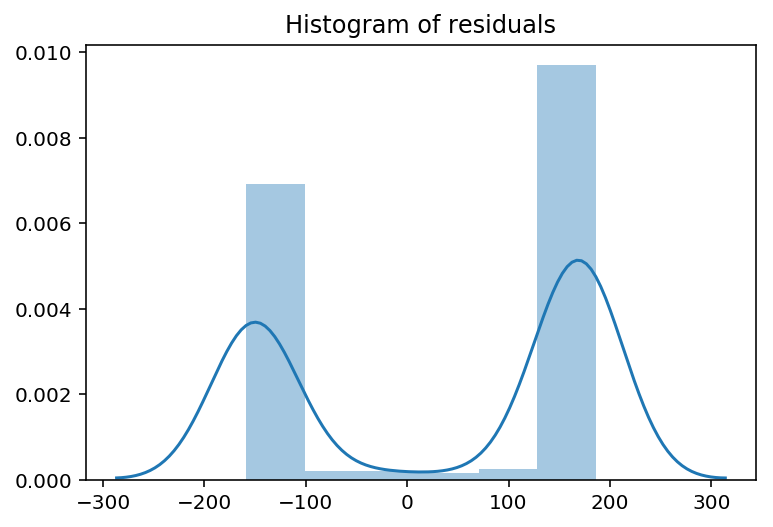

In [41]:
X_train,X_test = stf.scaler(X_train,X_test)
regression = True
D_l = np.array([X_train.shape[1]-1,5,10,1]) #architecture

w = nn_stoch_grad_des(X_train,y_train,D_l,eta=0.01, sigma = 1/10,iterations = 20000,regression=regression,_lambda=0.001)
g_train = stf.nn_predict_all(X_train,w,regression)
print(f"training R2 = {stf.R2(g_train,y_train)}, MAE = {stf.MAE(g_train,y_train)}")
g_test = stf.nn_predict_all(X_test,w,regression)
print(f"testing R2 = {stf.R2(g_test,y_test)}, MAE = {stf.MAE(g_test,y_test)}")
sns.distplot(y_test-g_test)
plt.title("Histogram of residuals")
plt.show()


#### Regularized Linear Regression

Best results:
    
    training R2 = 0.5429422417634518, MAE = 1.5925524230358235
    testing R2 = 0.4919180691142102, MAE = 1.5443317664719274



training R2 = 0.5448882714330099, MAE = 1.5950563425284605
testing R2 = 0.490596042127582, MAE = 1.5476619362999466


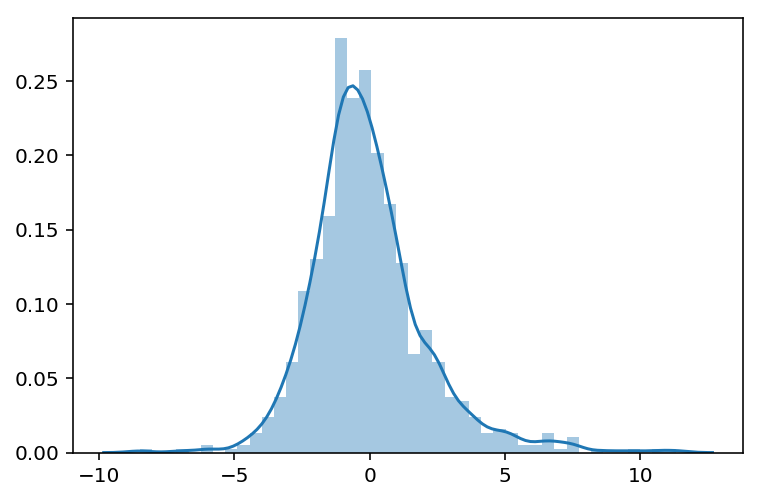

In [42]:
w = linear_fit(X_train,y_train,lamby=1/10)
g_train = X_train.dot(w)
g_test = X_test.dot(w)

print(f"training R2 = {stf.R2(g_train,y_train)}, MAE = {stf.MAE(g_train,y_train)}")
print(f"testing R2 = {stf.R2(g_test,y_test)}, MAE = {stf.MAE(g_test,y_test)}")

sns.distplot(y_test-g_test)
plt.show()

#### Lasso Regression

Best Scores:
    
    training R2 = 0.5282469420647975, MAE = 1.6153854620793155
    testing R2 = 0.48277723702559605, MAE = 1.5642478977380916



training R2 = 0.5283157307075055, MAE = 1.6154256052986111
testing R2 = 0.4827182020285177, MAE = 1.5643987913654542


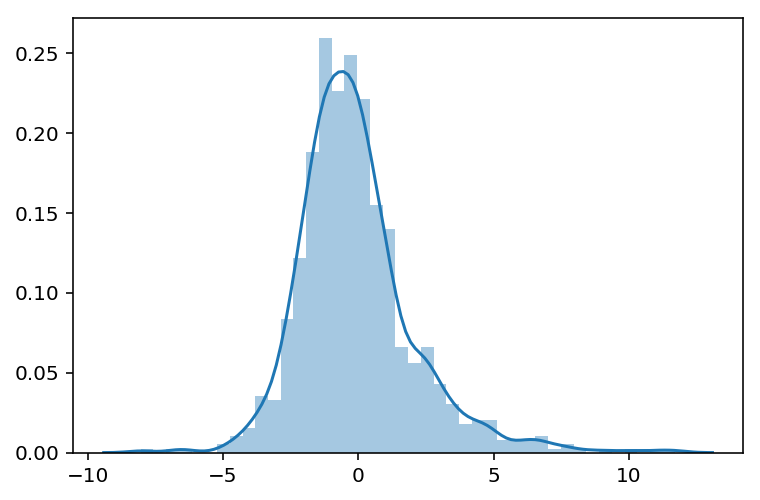

In [43]:


w = grad_des_lasso(X_train,y_train,eta=0.001,iterations=20000,_lambda = 0.001)
g_train = X_train.dot(w)
g_test = X_test.dot(w)

print(f"training R2 = {stf.R2(g_train,y_train)}, MAE = {stf.MAE(g_train,y_train)}")
print(f"testing R2 = {stf.R2(g_test,y_test)}, MAE = {stf.MAE(g_test,y_test)}")

sns.distplot(y_test-g_test)
plt.show()

#### Linear Regression with Transformation

Here we add more columns to the Abalone data. For each of the 8 existing columns, we add a copies of those columns with the Legendre Polynomials $P_2$, $P_3$ and $P_4$ applied.  You can think of this transformation itself as a hyperparameter that you can try adjusting. 

Best results:

    training R2 = 0.581192895390694, MAE = 1.528014485842905
    testing R2 = 0.5146011702688812, MAE = 1.4978250771702546


training R2 = 0.5874555064480422, MAE = 1.5162626502799128
testing R2 = 0.5068117603610877, MAE = 1.4983631655018796


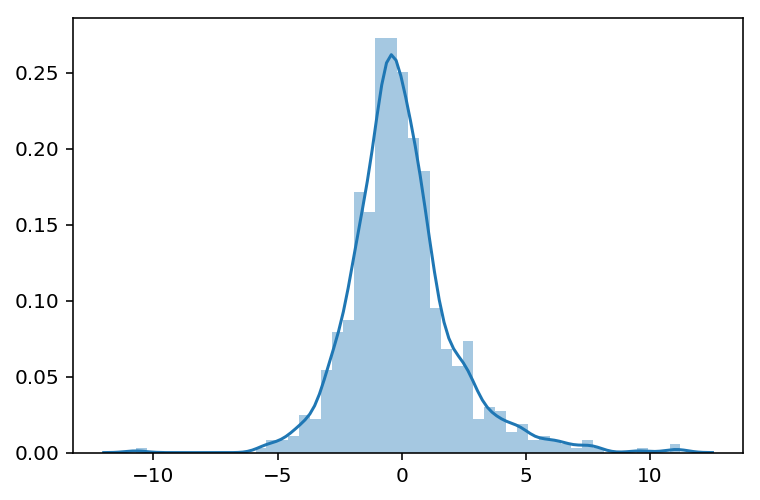

In [44]:

deg = 4

Z1 = legendre_transform(X[:,1],deg)
Z2 = legendre_transform(X[:,2],deg)
Z3 = legendre_transform(X[:,3],deg)
Z4 = legendre_transform(X[:,4],deg)
Z5 = legendre_transform(X[:,5],deg)
Z6 = legendre_transform(X[:,6],deg)
Z7 = legendre_transform(X[:,7],deg)
Z8 = legendre_transform(X[:,8],deg)

Z = np.c_[X,Z1[:,2:],Z2[:,2:],Z3[:,2:],Z4[:,2:],Z5[:,2:],Z6[:,2:],Z7[:,2:],Z8[:,2:]]

Z_train,Z_test,y_train,y_test = stf.test_train_split(Z,y)

w = linear_fit(Z_train,y_train,lamby=1/100)

g_train = Z_train.dot(w)
g_test = Z_test.dot(w)

print(f"training R2 = {stf.R2(g_train,y_train)}, MAE = {stf.MAE(g_train,y_train)}")
print(f"testing R2 = {stf.R2(g_test,y_test)}, MAE = {stf.MAE(g_test,y_test)}")
sns.distplot(y_test-g_test)
plt.show()

#### Neural Network on Transformed Data

Just out of curiosity we run the $Z$ data through a neural network to see what happens.

Best scores:
    
    training R2 = 0.5767770862183408, MAE = 1.5421753474694788
    testing R2 = 0.5177323326531311, MAE = 1.489459730272882


training R2 = -54.54068912992504, MAE = 23.465155833981363
testing R2 = -66.58577797961375, MAE = 23.67948290911354


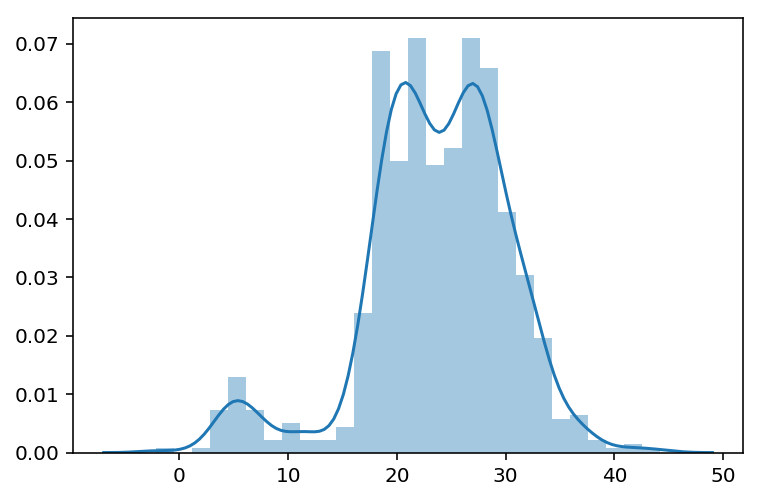

In [45]:

regression = True
D_l = np.array([Z_train.shape[1]-1,10,15,1]) #architecture
w = nn_stoch_grad_des(Z_train,y_train,D_l,eta=0.01, sigma = 1,iterations = 20000,regression=regression,_lambda=0.001)
g_train = stf.nn_predict_all(Z_train,w,regression)
print(f"training R2 = {stf.R2(g_train,y_train)}, MAE = {stf.MAE(g_train,y_train)}")
g_test = stf.nn_predict_all(Z_test,w,regression)
print(f"testing R2 = {stf.R2(g_test,y_test)}, MAE = {stf.MAE(g_test,y_test)}")
sns.distplot(y_test-g_test)
plt.show()

#### Linear Regression with Transformation 2

In the above transformation $Z$ we didn't combine any of the columns, we just adjusted them independently.

Let's try the "add_squares" transformation which combines columns.  

Best scores:
    
    training R2 = 0.5985986897138315, MAE = 1.487709646750359
    testing R2 = 0.5079048377741733, MAE = 1.4850614465507888


training R2 = 0.5985986897137989, MAE = 1.4877096470052082
testing R2 = 0.5079048376453226, MAE = 1.4850614468762546


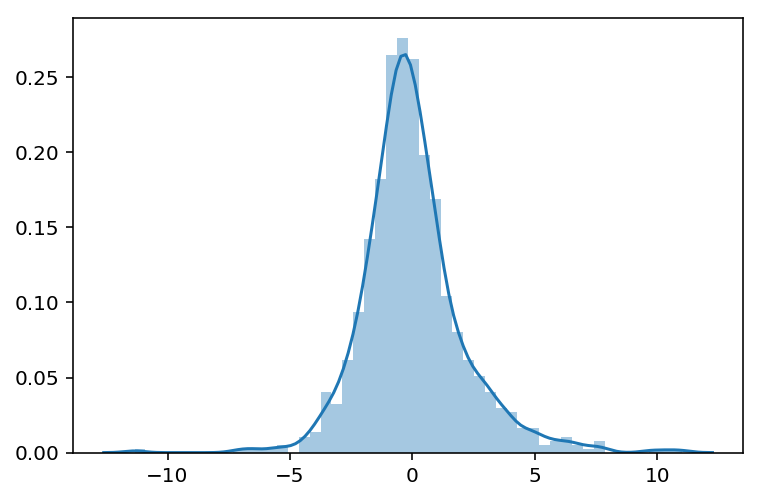

In [46]:
Z = stf.add_squares(X)

Z_train,Z_test,y_train,y_test = stf.test_train_split(Z,y)

w = linear_fit(Z_train,y_train,lamby=.000001)

g_train = Z_train.dot(w)
g_test = Z_test.dot(w)

print(f"training R2 = {stf.R2(g_train,y_train)}, MAE = {stf.MAE(g_train,y_train)}")
print(f"testing R2 = {stf.R2(g_test,y_test)}, MAE = {stf.MAE(g_test,y_test)}")
sns.distplot(y_test-g_test)
plt.show()

### Hyperparameter Optimization

From the above we learned that model families can have a lot of hyperparameters and they can interact in complex ways.

For example, it seems reasonable to check at least the following hyperparameters when fitting a neural network:

    Etas = [0.0001,0.001,0.01]
    Lambdas = [0.00001,0.0001,0.001,0.01,0.1,1,10]
    Sigmas = [1,1/10,1/100,1/1000]
    Layer1s = [5,10,15]  ### Number of nodes in layer 1
    Layer2s = [5,10,15]  ### Number of nodes in layer 2
    
This does not even take into account trying different activation functions, optimization algorithms, data transformations, or networks with more or less than two hidden layers. Also we are basically only checking "order of magnitude" values for the hyperparameters, not trying to tune them precisely. Yet we already need to painstakingly train and test $3\times 7 \times 4 \times 3 \times 3 = 756$ neural networks to see which one works best.  

With these possibilities, the neural network that works best on the Abalone data turns out to have an R2 score of about 0.53 on the test set.  

#### Part 4

Suppose we found some new stash of Abalone data.  Would you expect the best neural network we found (with an R2 score of 0.53) to continue to perform at a performance level of $R2 = 0.53$ on the new data?  If not, why not? 

No. The Abalone data could be completely different from what was originally given. Even if the data WAS similar, it was still biased, which would change the R2 score when focused on a completely new set of data.


#### Interlude

Just killing time while you think about Part 4.

#### Uh...

For Part 4 you should have said that R2=0.53 is an optimistically biased estimate of the performance of our best neural network on new data.  There is no way that the model is actually that good.  That's because we tried 756 hypotheses on the "test data" and picked the best one.  But the whole idea of test data is that it is independent of $g$.  That's what makes test performance a good measure of out of sample performance.

So in selecting the best model, we "ruined" our test set as something we can use to estimate out of sample performance.  Because we tried so many hypotheses we have to worry that $g$ is not only good, but also lucky (lucky with respect to the particular form of the test dataset).  This $g$ will continue to be "good" but in the future it won't be lucky, and therefore performance will drop compared to what we've seen so far. 

#### Validation

The solution to this problem is to set aside a part of the dataset for hyperparameter tuning _as well as_ a portion for testing.  This set aside portion is called a validation set.  We demonstrate this below with the abalone data. 

First we set aside 20% of the data for testing.  Then we set aside 20% of the _remaining_ data for validation.  The bulk of the data will be used for training. 


In [47]:



df = pd.read_csv("abalone.data")

vals = df.values
X = np.c_[np.ones(vals.shape[0]),vals[:,:-1]]
y = vals[:,-1]

X_nottest,X_test,y_nottest,y_test = stf.test_train_split(X,y,train_percent = 0.80,rand_seed=100)
X_nottest,X_test = stf.scaler(X_nottest,X_test)

X_train, X_val,y_train,y_val = stf.test_train_split(X_nottest,y_nottest)

X_train.shape[0],X_val.shape[0],X_test.shape[0]

(2672, 668, 836)

#### Grid Search

Now we experiment to find the best combination of $d^{(1)}$ and $d^{(2)}$ for this dataset when using a neural network model.  We fix the other hyperparameters as seen in the code below in this line:
    
    w = nn_stoch_grad_des(X_train,y_train,D_l,eta=0.001, sigma = 1/10,iterations = 2000,regression=regression,_lambda=0.00001)

Under the current configuration we exhaustively check all possible values for $d^{(1)}$ and $d^{(2)}$ in the range 1-20. 

This kind of exhaustive exploration of the hyperparameter space is called _grid search_.

In [48]:
regression = True

k = 20
step = 1

train_scores = np.zeros((k//step+1//step,k//step+1//step))
val_scores = np.zeros((k//step+1//step,k//step+1//step))
test_scores = np.zeros((k//step+1//step,k//step+1//step))

train_max, val_max,test_max = (1,1),(1,1),(1,1)
for l1 in range(1,k+1,step):
    for l2 in range(1,k+1,step):
        D_l = np.array([X_train.shape[1]-1,l1,l2,1]) #architecture
        w = nn_stoch_grad_des(X_train,y_train,D_l,eta=0.001, sigma = 1/10,iterations = 2000,regression=regression,_lambda=0.00001)
        g_train = stf.nn_predict_all(X_train,w,regression)
        if stf.R2(g_train,y_train) > np.max(train_scores):
            train_max = (l1,l2)
        train_scores[l1//step][l2//step] = stf.R2(g_train,y_train)
        g_val = stf.nn_predict_all(X_val,w,regression)
        if stf.R2(g_val,y_val) > np.max(val_scores):
            val_max = (l1,l2)
        val_scores[l1//step][l2//step] = stf.R2(g_val,y_val)
        g_test = stf.nn_predict_all(X_test,w,regression)
        if stf.R2(g_test,y_test) > np.max(test_scores):
            test_max = (l1,l2)
        test_scores[l1//step][l2//step] = stf.R2(g_test,y_test)


#### Best performance

Below we see the best performing combinations for the training, validation, and test sets, respectively.

Note that the training and validation sets agree on their choice of $d^{(1)}=11$ and $d^{(2)}=20$, but for the testing set there is a different maximum.  

Nevertheless, the values 11,20 will be used on the test set to find an estimate for out of sample error.  Because the test set had nothing to do with the selection of these hyperparameters, the out of sample error for performance we get using these parameters on the test set is unbiased. 

If the test and validation sets had happened to disagree, we would have let the validation set decide, because the validation error is less biased than the training error.  That's because we evaluated $20\times 20 = 400$ hypotheses on the validation set, but $2000\times 400 = 800000$ hypotheses on the training set. (2000 is the number of iterations in stochastic gradient descent.)  Therefore the best hypothesis on the validation set is probably less "lucky" and more "good" than the best hypothesis on the training set. 

How many hypotheses did we evaluate on the test set?  Just one!  That's why this is the best estimate of out of sample performance. 

In [49]:
train_max,val_max,test_max, np.max(train_scores),np.max(val_scores),np.max(test_scores)

((1, 1), (1, 1), (1, 1), 0.0, 0.0, 0.0)

#### Visualizing the grid

Below we visualize the hyperparameter space we explored using grid search.  The performance surface seems to be interesting -- it looks like a wavy mountain whose peak is somewhere in the unexplored southeast.  


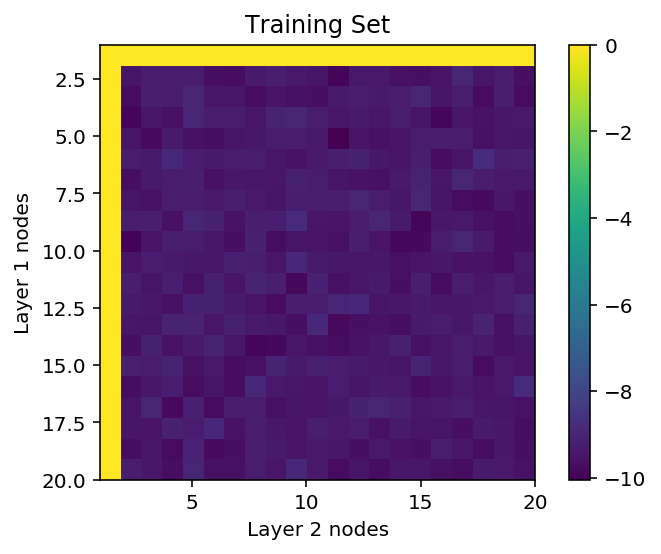

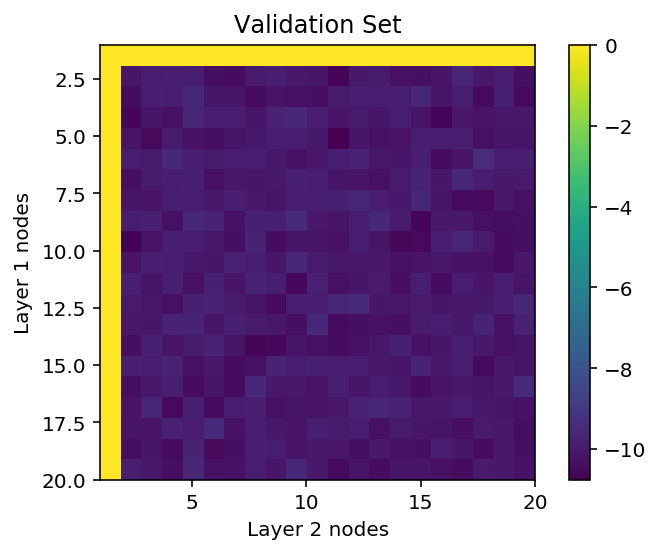

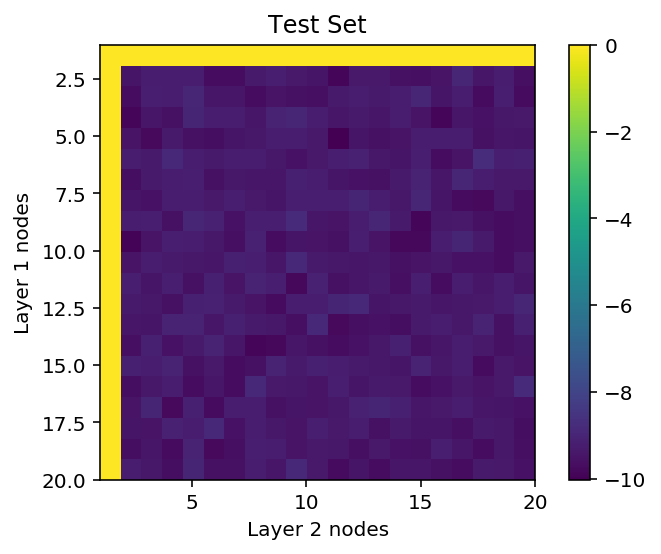

In [50]:
plt.imshow(train_scores,extent=[1,k,k,1])
plt.xlabel("Layer 2 nodes")
plt.ylabel("Layer 1 nodes")
plt.title("Training Set")
plt.colorbar()
plt.show()

plt.title("Validation Set")
plt.xlabel("Layer 2 nodes")
plt.ylabel("Layer 1 nodes")
plt.imshow(val_scores,extent=[1,k,k,1])
plt.colorbar()
plt.show()

plt.title("Test Set")
plt.xlabel("Layer 2 nodes")
plt.ylabel("Layer 1 nodes")
plt.imshow(test_scores,extent=[1,k,k,1])
plt.colorbar()
plt.show()


#### The bottom line

We now see how the model does with the $d^{(1)}$ and $d^{(2)}$ values chosen based on the validation set, when error is evaluated in the test set.  The estimate we get for out of sample performance is good -- about as good as we had naively believed out of sample performance to be when we were validating using the test set. 

Out of sample, we expect $R2 \approx 0.532$.


In [51]:
D_l = np.array([X_train.shape[1]-1,11,20,1]) #architecture
w = nn_stoch_grad_des(X_train,y_train,D_l,eta=0.001, sigma = 1/10,iterations = 2000,regression=regression,_lambda=0.00001)
g_test = stf.nn_predict_all(X_test,w,regression)
print(stf.R2(g_test,y_test))

-9.443451492571418


#### The Last Part

Suppose that we assume that the hyperparameters for a neural network take on the following possible values:
    
    Etas = [0.00001,0.0001,0.001]
    Lambdas = [0.000001,0.00001,0.0001,0.001]

Assume that we will use, 11 and 20 for the number of nodes in layer 1 and layer 2, respectively. Assume that $\sigma = 1/2$. 

1. Which of these parameter choices performs best on the validation set?
1. What is the resulting R2 score on the test set for the hyperparameters that work best on the validation set?

In other words you will do your own grid search using the grid described above. It would be nice if you also made a visualization. 
